<h1>
<center>CFRM 421/521, Spring 2023</center>
</h1>

<h1>
<center>Yoshihiro Shirai</center>
</h1>

<h1>
<center>Homework 2</center>
</h1>

* **Due: Monday, April 29, 2024, 11:59 PM**


* Total marks: 45


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as both one Jupyter notebook and one PDF file on Gradescope.** There will be two modules on Gradescope, one for each file type. The notebook must be already run, that is, make sure that you have run all the code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Random forest for time series data [14 marks]

In this question you will work with the NYSE dataset. Only 3 time series in this dataset will be use: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/105167110/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf), which explains the meaning of the variables.

You want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

If the data is stored in a file named `NYSE.csv` in your working directory, then loading the data can be done using the code below.

In [1]:
import os
import pandas as pd
data = pd.read_csv("datasets/NYSE.csv")

c:\Users\yoshi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\yoshi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## (a) [3 marks]

Create the feature matrix `X` and the target variable `y`. Print at least the first 2 rows of `X` and `y` (it is acceptable that not every element of the rows are printed).

**Solution:**

Use the `ts_split` function to create the features and target for each series, and column bind the features.

In [2]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

log_volume = data["log_volume"]
log_volatility = data["log_volatility"]
DJ_return = data["DJ_return"]

def ts_split(ts, feature_steps=8, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

X_log_volume, y = ts_split(log_volume, feature_steps = 5, target_steps = 1)
X_log_volatility, y_log_volatility = ts_split(log_volatility, feature_steps = 5, target_steps = 1)
X_DJ_return, y_DJ_return = ts_split(DJ_return, feature_steps = 5, target_steps = 1)

X = np.c_[X_log_volume,X_log_volatility,X_DJ_return]


In [3]:
X[:2]

array([[ 3.25730000e-02,  3.46202000e-01,  5.25306000e-01,
         2.10182000e-01,  4.41870000e-02, -1.31274026e+01,
        -1.17493047e+01, -1.16656090e+01, -1.16267724e+01,
        -1.17281302e+01, -4.46100000e-03,  7.81300000e-03,
         3.84500000e-03, -3.46200000e-03,  5.68000000e-04],
       [ 3.46202000e-01,  5.25306000e-01,  2.10182000e-01,
         4.41870000e-02,  1.33246000e-01, -1.17493047e+01,
        -1.16656090e+01, -1.16267724e+01, -1.17281302e+01,
        -1.08725263e+01,  7.81300000e-03,  3.84500000e-03,
        -3.46200000e-03,  5.68000000e-04, -1.08240000e-02]])

In [4]:
y[:2]

array([[ 0.133246],
       [-0.011528]])

## (b)  [5 marks]

Consider fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest must include the argument `random_state=42`, and it is useful to also include `n_jobs=-1` (you can use `n_job=-1` throughout this homework wherever it is avaliable). Use 3-fold time series CV split, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  200, 400, 600, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=1,3,5,7$. When tuning hyperparameters on the validation sets, fit the model only on a random 10% sample of the instances of the training set on the same CV fold to reduce computational time (that is, use the same reduced training set for all the hyperparameters, but a different one for each CV fold). Note this will still preserve the correct time ordering, and the reduce training set should not be used when fitting and evaluating the best model on the test set. The performance measure is RMSE. Report the best hyperparameters.

**Solution:**

Use the `time_series_valid_test` code in the notes and adjust the hyperparameters. (The code also includes changes for (c)-(e))

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

series_len = log_volume.size
tscv = TimeSeriesSplit(n_splits=3)

# Hyperparamter combinations
ccp_alpha_list = [10**-1, 10**-3, 10**-5, 10**-7]
n_estimators_list = [200,400,600]

def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    currentval_rmse = []
    i = 0
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            X_train_red, X_train_rest, y_train_red, y_test_red = train_test_split(
                X_train, y_train, test_size=0.1, random_state=42)
            for ccp_alpha in ccp_alpha_list:
                for n_estimators in n_estimators_list:
                    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1,
                               ccp_alpha=ccp_alpha, n_estimators=n_estimators)
                    model_rf.fit(X_train_red, y_train_red.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
        
        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42, n_jobs=-1,
                       ccp_alpha=optimal_par[0], n_estimators=optimal_par[1])
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))
            
            # Predicting as next value as the current value
            y_test_currentval = y[test_index-1]
            currentval_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_currentval)))
            
            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, "r--", label="True value", )
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="1-steps ahead prediction")
                plt.legend(loc="lower left")
    
    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse = np.mean(np.array(rf_rmse).reshape(
            n_split, len(ccp_alpha_list)*len(n_estimators_list)), axis=0)
        return rf_rmse
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        currentval_rmse = np.mean(currentval_rmse)
        
        # Returns: RF RMSE, Current value prediction RMSE, best fitted RF model
        return rf_rmse, currentval_rmse, model_rf

The following prints the best hyperparameters.

In [6]:
rf_rmse = time_series_valid_test(X, y, 3, "valid")
print(rf_rmse)
ind = 0
for ccp_alpha in ccp_alpha_list:
        for n_estimators in n_estimators_list:
            if ind == np.argmin(rf_rmse):
                optimal_par = [ccp_alpha, n_estimators]
                print(["(ccp_alpha, n_estimators):",[ccp_alpha, n_estimators]])
                print(rf_rmse[ind])
            ind += 1

[0.2358372  0.23586555 0.2358684  0.17323972 0.17319774 0.17323159
 0.15944293 0.15929888 0.15938586 0.15956617 0.15950782 0.15955879]
['(ccp_alpha, n_estimators):', [1e-05, 400]]
0.15929888399294856


The best hyperparameter are `ccp_alpha = 1e-5` and `n_estimators=400`.

## (c)  [2 marks]

Using the same time series split as in (b), compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

**Solution**:

Now evaulate the best model on the test set

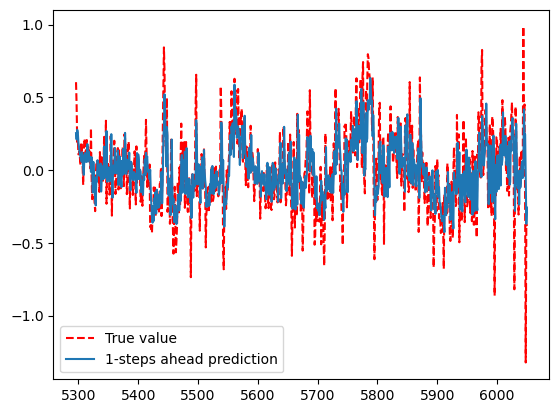

In [7]:
rf_rmse, currentval_rmse, model_rf = time_series_valid_test(X, y, 3, "test", optimal_par)

Here is the RMSE on the test set (i.e. the average RMSE over the 3 test sets from the time series CV).

In [8]:
rf_rmse

0.18704773048680057

## (d) [2 marks]

It is often useful to check that your model is not worse than a very simple method of prediction. On the test set, compute the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

**Solution**:

We have adjusted the time_series_valid_test function to also compute the RMSE on the test set in a way that is comparable to the above RMSE (averaged over the CV folds).

In [9]:
currentval_rmse

0.21692013508591304

This simple method is worse than random forest, as expected.

## (e) [2 marks]

Compute the feature importances of the best fitting model. Which feature is the most important and what is its feature importance value?

**Solution:**

We have adjusted the `time_series_valid_test` function to return the best fitting model. The best fitting model is the one trained with the best hyperparameters on the last fold of the CV (i.e. with the most training data).

In [10]:
model_rf.feature_importances_

array([0.05117944, 0.0604029 , 0.03628928, 0.03430134, 0.56688246,
       0.01343828, 0.01130596, 0.01018653, 0.01253518, 0.01408949,
       0.02926346, 0.02763519, 0.03360936, 0.04001519, 0.05886596])

The feature with the most importance for predicting the next value of `log_volume` $c_{t+1}$ is the current value of log_volume $c_t$ with feature importance 51.2%.

# 2. SVM classification and regression [11 marks]

For all SVM models in this question use a standard scaler.

## (a) [2 marks]

In this question, a SVM is used for classification for the MNIST dataset. The following code loads the MNIST dataset, creates the test set, and to reduce training time, takes a random sample of 2000 points from the full training set to use as your actual training set stored in `X` and `y`. Do not shuffle the data.

Hint: Reading the solution to Question 9 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) (2nd edition) on the textbook website may help with this question.

In [11]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=True, parser='auto')
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

N = 2000
split_obj = StratifiedShuffleSplit(n_splits=1,
                               test_size=N/60000, random_state=42)
for other_idx, subsample_idx in split_obj.split(X_train, y_train):
    X = X_train[subsample_idx]
    y = y_train[subsample_idx]

**Task:** Consider fitting the linear SVM classifier (`LinearSVC`) with `max_iter=50000`. For this model, optimize the hyperparameter $C$ using 3-fold CV over the values $10^{-k}$, $k=0,1,\dots,9$, where the performance measure is accuracy. What is the best $C$ and what is the accuracy in this case?

**Solution:**

The scoring uses accuracy by default for this `LinearSVC`.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

linsvc = Pipeline([('scaler', StandardScaler()),
                   ('linear_svc', LinearSVC(max_iter=50000))
               ])

param_grid = {"linear_svc__C": np.power(10,-1*np.arange(10,dtype=float))}

grid_search_linsvc = GridSearchCV(linsvc, param_grid,
                                  cv=3,
                                  verbose=1, n_jobs=-1, scoring="accuracy")
%time grid_search_linsvc.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\yoshi\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Wall time: 12.1 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linear_svc',
                                        LinearSVC(max_iter=50000))]),
             n_jobs=-1,
             param_grid={'linear_svc__C': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             scoring='accuracy', verbose=1)

Take a look at the search results and recall grid search and randomized search has automatically fit the best model.

In [14]:
print(grid_search_linsvc.best_params_)
print(grid_search_linsvc.best_score_)

{'linear_svc__C': 0.01}
0.8329911620766194


Best $C=10^{-2}$, accuracy is $0.833$.

## (b) [2 marks]

**Task:** Now consider fitting a SVM with a Gaussian RBF kernel and `max_iter=50000`. For this model, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` from `scipy.stats.loguniform` with 10 random samples. The `loguniform(a,b)` function takes a random sample from the probability distribution with pdf $f(x)\propto 1/x, x\in[a,b]$. Again, use 3-fold CV and the performance measure is accuracy. What are the best hyperparameters and what is the accuracy in this case?

**Solution:**

Let us train an SVM with a Gaussian RBF kernel, this time using randomized search.

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.svm import SVC

kersvc = Pipeline([('scaler', StandardScaler()),
                   ('svc', SVC(max_iter=50000))
               ])

param_distributions = {"svc__gamma": loguniform(0.0001, 0.1),
                       "svc__C": uniform(1, 10)
                       }

rnd_search_kersvc = RandomizedSearchCV(kersvc, param_distributions,
                                       cv=3, n_iter=10,
                                       verbose=1, n_jobs=-1,
                                       random_state=42, scoring="accuracy")
%time rnd_search_kersvc.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 7.53 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(max_iter=50000))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E21A7C940>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E21A1D580>},
                   random_state=42, scoring='accuracy', verbose=1)

In [16]:
print(rnd_search_kersvc.best_params_)
print(rnd_search_kersvc.best_score_)

{'svc__C': 9.324426408004218, 'svc__gamma': 0.00043352817949515634}
0.8904999452225839


Best $C=9.32$ and $\gamma =4.34\times 10^{−4}$, accuracy is $89%$.

## (c) [2 mark]

**Task:** Choose the best model in (a) and (b). Then for this model, evaluate the accuracy on the test set, which is stored in `X_test` and `y_test`.

**Solution:**

Here's the accuracy for the best model on the test set (SVC in (b)).

In [17]:
from sklearn.metrics import accuracy_score
y_pred = rnd_search_kersvc.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.909

We get 91% accuracy, which is pretty high given we're only using 3.33% of the full training data, far better than random guessing (10% accuracy).

## (d) [3 marks]

Consider the original source of the California housing data (which is different from the modified dataset used in Homework 1) in Scikit-Learn. The data is obtained and split using the code below. The training set is stored in `X_train` and `y_train`. Do not shuffle the data.

Hint: Reading the solution to Question 11 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/05_support_vector_machines.ipynb) (3rd edition) on the textbook website may help with this question.

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X = housing.data
y = housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Task:** Consider SVM regression with a Gaussian RBF kernel and a sigmoid kernel with `max_iter=50000`. For both models, use randomized search to choose good hyperparameter values for `C` and `gamma`, and set the arguement `random_state=42`. For both models, optimize the hyperparameters $C$ over the distrbution `uniform(1,20)` and $\gamma$ over the distribution `loguniform(0.0001, 0.1)` with 20 random samples. To save training time, use only the first 2000 instances of `X_train` and `y_train` (which have been randomly shuffled already) for the search. Again, use 3-fold CV and the performance measure is MSE. What are the best hyperparameters and what is the MSE in this case?

**Solution:**

We train a SVM regression with a Gaussian RBF kernel using a randomized search.

In [19]:
from sklearn.svm import SVR

rbfsvr = Pipeline([('scaler', StandardScaler()),
                   ('svr', SVR(max_iter=50000))
               ])

param_distributions = {"svr__gamma": loguniform(0.0001, 0.1),
                       "svr__C": uniform(1, 20)
                       }

rnd_search_rbfsvr = RandomizedSearchCV(rbfsvr, param_distributions,
                                       cv=3, n_iter=20,
                                       verbose=1, n_jobs=-1,
                                       scoring="neg_mean_squared_error",
                                       random_state=42)
%time rnd_search_rbfsvr.fit(X_train[:2000], y_train[:2000])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Wall time: 1.27 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svr', SVR(max_iter=50000))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E219EF280>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E3419E1C0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

Take a look at the search results and fit the training data to the best model.

In [20]:
print(rnd_search_rbfsvr.best_params_)
print(-rnd_search_rbfsvr.best_score_)

{'svr__C': 8.49080237694725, 'svr__gamma': 0.07114476009343418}
0.3176244439566452


Next, let us train a SVM regression with a sigmoid kernel. We use a randomized search.

In [21]:
sigsvr = Pipeline([('scaler', StandardScaler()),
                   ('svr', SVR(kernel="sigmoid", max_iter=50000))
               ])

param_distributions = {"svr__gamma": loguniform(0.0001, 0.1),
                       "svr__C": uniform(1, 20)
                       }

rnd_search_sigsvr = RandomizedSearchCV(sigsvr, param_distributions,
                                       cv=3, n_iter=20,
                                       verbose=1, n_jobs=-1,
                                       scoring="neg_mean_squared_error",
                                       random_state=42)
%time rnd_search_sigsvr.fit(X_train[:2000], y_train[:2000])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Wall time: 1.08 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svr',
                                              SVR(kernel='sigmoid',
                                                  max_iter=50000))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E3419ECD0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016E21A7C130>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

Take a look at the search results and fit the training data to the best model.

In [22]:
print(rnd_search_sigsvr.best_params_)
print(-rnd_search_sigsvr.best_score_)

{'svr__C': 6.842892970704363, 'svr__gamma': 0.0012562773503807024}
0.4895822473788191


The best hyperparameters are the Gaussian RBF kernel with $C=8.4908$ and $\gamma = 0.0711$, and the MSE is 0.3176.

Note: It's acceptable to combine both searches together.

## (e) [2 marks]

**Task:** Choose the best model in (d). But now refit it on the full training set (not just the first 2000 instances). Then for this model, evaluate the RMSE on the test set, which is stored in `X_test` and `y_test`.

**Solution:**

We refit the full training set using the Gaussian RBF SVR which was the best model in (d), and using the `.best_estimator_` to pick out the estimator with the best hyperparameter choice.

In [23]:
%time rnd_search_rbfsvr.best_estimator_.fit(X_train, y_train)

Wall time: 8.43 s


c:\Users\yoshi\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 SVR(C=8.49080237694725, gamma=0.07114476009343418,
                     max_iter=50000))])

Here's the results for the Gaussian RBF SVR on the test set.

In [24]:
y_pred = rnd_search_rbfsvr.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

c:\Users\yoshi\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.5919498204785005

The RMSE is 0.5919.

Alternatively, you can increase the number of iterations to fix the failure to converge. The result on the test set is very similar.

In [25]:
rnd_search_rbfsvr.best_estimator_.set_params(svr__max_iter=10**6).fit(X_train, y_train)
y_pred = rnd_search_rbfsvr.best_estimator_.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.5919058119150435

# 3. Voting classifiers [11 marks]
## (a)  [4 marks]

Consider the MNIST dataset. To save computational time, after spliting into a training, validation and test set, we keep only the first 5000 instances of the training set, and only the first 1000 instances of the validation and test set, as given by the following code.

In [26]:
N = 50_000
M = 60_000
X_train = mnist["data"][:N][:5000]
y_train = mnist["target"][:N][:5000]
X_valid  = mnist["data"][N:M][:1000]
y_valid = mnist["target"][N:M][:1000]
X_test  = mnist["data"][M:][:1000]
y_test = mnist["target"][M:][:1000]

Do not shuffle the data and do not use a standard scaler. Train the following classifiers on the training set:

(i) a multilayer perceptron classifier using the class `MLPClassifier()` from `sklearn.neural_network` with arguments `random_state=42`,

(ii) an extra-trees classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(iii) an AdaBoost classifier  with arguments  `n_estimators=50, learning_rate=0.2, random_state=42`,

(iv) a gradient boosting classifier using the class `GradientBoostingClassifier()` with arguments `max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42`.

Report the accuracy of each trained classifier on the validation set.

Hint: Reading the solution to Question 8 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

**Solution:**

(i) multilayer perceptron classifier accuracy on the validation set. Note that using the .score() method gives the accuracy.

In [27]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=42)
%time mlp_clf.fit(X_train, y_train)
mlp_clf.score(X_valid, y_valid)

Wall time: 4.86 s


0.879

(ii) Extra trees accuracy on the validation set

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

extratrees = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)
%time extratrees.fit(X_train, y_train)
extratrees.score(X_valid, y_valid)

Wall time: 272 ms


0.944

(iii) AdaBoost accuracy on the validation set. This uses 50 decision stumps, which we could increase for better accuracy, but that would take a lot of time.

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.2, random_state=42)
%time ada.fit(X_train, y_train)
ada.score(X_valid, y_valid)

c:\Users\yoshi\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Wall time: 3.24 s


0.701

(iv) Gradient boost accuracy on the validation set. This uses 10 estimators. As in the AdaBoost classifier, we can increase the ensemble at the cost of longer training times.

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42)
%time gb.fit(X_train, y_train)
gb.score(X_valid, y_valid)

Wall time: 8.95 s


0.802

Alternative method: Instead of `GradientBoostingClassifier`, it is possible to use the `XGBoost` package (though the question says to use the former). The code below uses 2 early stopping rounds, that is, increase the number of estimators until the loss increases 2 times in a row. The `LabelEncoder` class is used to transform these labels to integers.

In [31]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
y_train_num = lab_encoder.fit_transform(y_train)
y_valid_num = lab_encoder.fit_transform(y_valid)

xgb = XGBClassifier(early_stopping_rounds=2, random_state=42)
%time xgb.fit(X_train, y_train_num, eval_set=[(X_valid, y_valid_num)])

[0]	validation_0-mlogloss:1.47186
[1]	validation_0-mlogloss:1.16199
[2]	validation_0-mlogloss:0.96299
[3]	validation_0-mlogloss:0.82146
[4]	validation_0-mlogloss:0.71027
[5]	validation_0-mlogloss:0.62748
[6]	validation_0-mlogloss:0.56281
[7]	validation_0-mlogloss:0.51249
[8]	validation_0-mlogloss:0.47288
[9]	validation_0-mlogloss:0.43876
[10]	validation_0-mlogloss:0.41130
[11]	validation_0-mlogloss:0.39093
[12]	validation_0-mlogloss:0.37235
[13]	validation_0-mlogloss:0.35781
[14]	validation_0-mlogloss:0.34569
[15]	validation_0-mlogloss:0.33561
[16]	validation_0-mlogloss:0.32674
[17]	validation_0-mlogloss:0.31911
[18]	validation_0-mlogloss:0.31360
[19]	validation_0-mlogloss:0.30411
[20]	validation_0-mlogloss:0.30087
[21]	validation_0-mlogloss:0.29761
[22]	validation_0-mlogloss:0.29547
[23]	validation_0-mlogloss:0.29148
[24]	validation_0-mlogloss:0.28856
[25]	validation_0-mlogloss:0.28589
[26]	validation_0-mlogloss:0.28335
[27]	validation_0-mlogloss:0.28150
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

The best iteration is 43 (lowest validation loss), which corresponds with 44 estimators (iteration 0 is 1 estimator). This can be confirmed by finding the minimum loss in the list above, and also with the code below.

In [32]:
xgb.best_iteration

43

In [34]:
xgb.best_ntree_limit

44

After training the classifier using `XGBoost`, you can predict the labels of the validation set using the ``.predict()`` method, and then convert the predicted labels back to their original string format using the ``.inverse_transform()`` method of the LabelEncoder class.

In [35]:
from sklearn.metrics import accuracy_score
y_pred = xgb.predict(X_valid)
accuracy_score(y_valid, lab_encoder.inverse_transform(y_pred))

0.923

## (b)  [5 marks]

Train the following models:

* a hard-voting ensemble classifier for all the models in (a)
* a soft-voting ensemble classifier for all the models in (a)
* a hard-voting ensemble classifier dropping the worst performing model in (a)
* a soft-voting ensemble classifier dropping the worst performing model in (a)

Evaluate the accuracy of these voting classifiers on the validation set, and compare it to the performance of the individual models in (a).

**Solution:**

Here is the accuracy of the hard voting classifier on the validation set

In [36]:
from sklearn.ensemble import VotingClassifier
vote_clf = VotingClassifier(estimators=[('mlp', mlp_clf), ('extra', extratrees), ('ada', ada), ('gb', gb)],
                          n_jobs=-1, voting="hard")
%time vote_clf.fit(X_train, y_train)
vote_clf.score(X_valid, y_valid)

Wall time: 13.9 s


0.896

Here is the accuracy of the soft voting classifier on the validation set. We can set voting="soft" without retraining.

In [37]:
vote_clf.voting = "soft"
vote_clf.score(X_valid, y_valid)

0.89

Now dropping the worst performing model (AdaBoost).

In [38]:
vote_clf_dropped = VotingClassifier(estimators=[('mlp', mlp_clf), ('extra', extratrees), ('gb', gb)],
                          n_jobs=-1, voting="hard")
%time vote_clf_dropped.fit(X_train, y_train)
vote_clf_dropped.score(X_valid, y_valid)

Wall time: 13.5 s


0.911

In [39]:
vote_clf_dropped.voting = "soft"
vote_clf_dropped.score(X_valid, y_valid)

0.888

Looking at the validation set performance, out of the 4 models the best is: "drop worst with hard voting" (91.3% accuracy). (The results show dropping the worst-performing model led to an improvement in the overall accuracy here).

Comparing it to models in (a) as well, the extra-trees classifier is the best (94.4%).

## (c)  [2 marks]

Of the four voting classifiers in (b), choose the best model. Then evaluate the accuracy of this model on the test set.

**Solution:**

Here is the accuracy of the "drop worst with hard voting" model on the test set

In [40]:
vote_clf_dropped.score(X_test, y_test)

0.884

# 4. Stacking [9 marks]

We continue with the setting of Question 3. The training set, validation set and test set are the same. In Question 3, we have used predetermined rules (that is, hard-voting and soft-voting) to build the ensemble prediction. **Stacking** is an ensemble method in which you train a model (called a **blender**) to aggregate the result of each predictor into an ensemble prediction.

Hint: Reading the subsection "Stacking" in Chapter 7 of the textbook and the solution to Question 9 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

## (a)  [3 marks]

For each of the four classifiers in Question 3(a), make 5000 clean predictions on the training set with 3-fold cross validation using `sklearn.model_selection.cross_val_predict()`. You should end up with four predictions per observation. Print at least the first 5 rows of `pred`. Next, apply one-hot encoding to `pred` since these predictions are class labels.

**Solution:**

The following code makes 3-fold cross validation predictions and stores them in `pred`.

Let's look at the output to check it is what we expect: a feature matrix with 50000 instances, each with 4 features, one prediction for each of the 4 estimators. We print the first 5 rows of `pred`.

In [41]:
from sklearn.model_selection import cross_val_predict

models = [mlp_clf, extratrees, ada, gb]
model_names = ["mlp", "ExtraTrees", "AdaBoost", "GradientBoost"]
pred = []
for idx, m_ in enumerate(models):
    pred.append(cross_val_predict(m_, X_train, y_train,
                                  cv=3, n_jobs=-1))
    print(model_names[idx])
pred = np.transpose(np.array(pred))
pred[:5]

mlp
ExtraTrees
AdaBoost
GradientBoost


array([['5', '5', '3', '3'],
       ['0', '0', '5', '0'],
       ['4', '4', '4', '4'],
       ['1', '1', '1', '1'],
       ['9', '9', '9', '9']], dtype=object)

Next, a one hot encoder is used since images predicted as a "1" are not any closer to an image predicted as a "2" than to a "7".

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

onehot_pipeline = Pipeline([
                    ("onehot", OneHotEncoder())
                  ])
pred_onehot = onehot_pipeline.fit_transform(pred)

To see what the data looks like after one-hot encoding (not requried by the question), use ``.todense()``.

In [44]:
pred_onehot.todense()[:2]

matrix([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

## (b) [3 marks]
Use the predictions in (a) as features and the actual label of the observations as the target. Train a random forest classifier on the training set with the parameters `n_estimators=100, random_state=42`.  This classifier is a blender. 

**Solution:**

We now fit a random forest with pred as features and the same labels `(y_pred)`.

In [45]:
from sklearn.ensemble import RandomForestClassifier
blender = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
%time blender.fit(pred_onehot, y_train)

Wall time: 232 ms


RandomForestClassifier(n_jobs=-1, random_state=42)

## (c) [3 marks]

Obtain the predictions of the blender on the test set by feeding predictions on the test set from the four classifiers in Question 3(a) into the blender trained in Question 4(b). Do not retrain the blender. These are called stacking predictions. Report the accuracy of your stacking predictions on the test set and compare this to the results in Question 3(c).

**Solution:**

We now use the blender to make predictions on the validation set. Note that training has already been done: the 4 models were trained on the training set in Question 3(a) and the blender was trained on the training set in Question 4(b).

To use the blender on the validation set, first we need to get the predictions of the 4 models on the validation set since these are the features that get inputed into the blender. Note that we now use .`predict`, not CV. Then these are passed into the onehot encoding pipeline.

In [46]:
estimators = [mlp_clf, extratrees, ada, gb]
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = blender.predict(onehot_pipeline.transform(X_test_predictions))
accuracy_score(y_test, y_pred)

0.924